# part 1. generation of problem instances

Consider the SKP with 10 items with independent and Bernoulli distributed resource requirements. Note that in this case the item size can take only two values, namely (𝑑_𝑙𝑖 and 𝑑_ℎ𝑖) with probabilities 𝑃(𝑤𝑖 = 𝑑_𝑙𝑖) = (1 − 𝜋𝑖) and 𝑃(𝑤𝑖 = 𝑑_ℎ𝑖) = 𝜋𝑖. Generate 10 random problem instances (𝑗 = 1, … ,10). Note that for each random instance, you only need to generate 𝑑_𝑙𝑖, 𝑑_ℎ𝑖, 𝜋𝑖 and 𝑟𝑖 for items 𝑖 = 1, 2, … . ,10 and compute 𝑝 and 𝐾 for your group.

In [382]:
import numpy as np
#fixed parameters
#group number g
g = 4
#risk parameter alpha in the two scenarios
r_ev = 0
r_cvar = 0.95
#unit excess weight penalty (p)
p=60+g/10
#capacity (K)
K=400+4*g

d_l = np.zeros(shape=(10,10))
d_h = np.zeros(shape=(10,10))
pie = np.zeros(shape=(10,10))    
r_i = np.zeros(shape=(10,10)) 
for j in range(0,10):    
    #generates variables for each instance
    for i in range(1, 11):
        gamma_y = np.random.poisson(i/2,1)
        d_l[j, i-1] = min(gamma_y, 10)
        d_h[j, i-1] = np.random.triangular(90+g-i, 100+g-i, 110+g-i)
        pie[j, i-1] = 0.5+0.05*i-0.001
        r_i[j, i-1] = 51-i

In [456]:
dh_avg = pd.DataFrame(d_h.mean(axis=0))
dh_avg['DH'] = pd.DataFrame(d_h.mean(axis=0))

In [458]:
dh_avg['DL'] = pd.DataFrame(d_l.mean(axis=0))
dh_avg['Probability'] = pd.DataFrame(pie.mean(axis=0))
dh_avg['Revenue'] = pd.DataFrame(r_i.mean(axis=0))

In [460]:
print(K)
print(p)

416
60.4


# part 2. heuristic algorithm

Develop a simple greedy heuristic algorithm to suggest an item selection strategy for the SKP problem
described above. No need to develop a complex solution method as that is not the focus. 

In [399]:
#uses a greedy heuristic algorithm to return the binary vector x_i indicating which item would be included in the knapsack 
#the function solves the problem for one instance j only
#inputs dl = 1x10 vector d_l for instance j, dh = 1x10 vector d_h for instance j
#pie = 1x10 vector of probabilities for instance j, r = 1x10 vector of revenue for instance j
def heuristics_knapsack(dl, dh, pie, r):
    #calculate the expected weight for each item
    expected_weight = ((1-pie)*dl+pie*dh)
    #calculate the expected revenue
    expected_revenue = expected_weight*r
    #calculate the ratio of revenue to cost (weight)
    exp_ratio = expected_revenue
    #sort the items based on the ratio; returns a list with the indexes of the items in descending order
    expected_revenue_sorted = np.argsort(-exp_ratio).tolist()
    #create the binary decision array with 0 being the default
    x_i = np.zeros(shape=(1,10))
    #define starting weight
    current_weight = 0
    #run the while loop until capacity is fully reached or we have run out of items
    while (current_weight<=K and len(expected_revenue_sorted)>0):
        #check if the next item with the highest revenue/cost ratio fits, and if yes - add it to the knapsach
        if (current_weight+expected_weight[expected_revenue_sorted[0]])<=K:
            current_weight+= expected_weight[expected_revenue_sorted[0]]
            x_i[0, expected_revenue_sorted[0]] = 1
            expected_revenue_sorted.pop(0)
        else:
            #if the next item with the highest revenue/cost ratio does not fit, check if the extra profit generated by it
            #exceeds the cost of adding it, and if yes - add it to knapsack
            if ((current_weight+expected_weight[expected_revenue_sorted[0]])-K)*p < expected_weight[expected_revenue_sorted[0]]*r[expected_revenue_sorted[0]]:
                current_weight+= expected_weight[expected_revenue_sorted[0]]
                x_i[0, expected_revenue_sorted[0]] = 1
                expected_revenue_sorted.pop(0)
            else:
                #get rid of the item so we can move on to the next
                expected_revenue_sorted.pop(0)
    #return the decision vector for each item
    return x_i

# part 3: Monte Carlo Simulation

For the first instance (j =1), apply your greedy heuristic algorithm and deliver decision variables 𝑥𝑖.

In [400]:
#our first j-instance is the 0-th indexed one
x = heuristics_knapsack(d_l[1,:],d_h[1,:], pie[0,:], r_i[0,:])
print(x)

for i in range(0, 10):
    print(heuristics_knapsack(d_l[i,:],d_h[i,:], pie[i,:], r_i[i,:]))

[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 1. 1. 1. 0. 1. 1.]]
[[0. 0. 0. 0. 1. 0. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 1. 1. 1. 0. 1. 1.]]


In [68]:
x

array([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])

For this selection vector (x), run Monte Carlo simulation to generate item sizes based on the Bernoulli
distribution to calculate the profit for the stochastic knapsack problem. 

In [59]:
#define the Monte Carlo simulations
from scipy import stats
def monte_carlo_sim(dh, dl, pie, r, number_runs, x):
    profits = np.zeros((1, number_runs))
    for i in range(0, number_runs):
        profits[0,i] = 0
        total_weight = 0
        for j in range(0, 10):
            if x[0, j] == 1:
                x_pie = stats.bernoulli(pie[j]).rvs(1)[0]
                x_weight = (x_pie)*dh[j]+(1-x_pie)*dl[j]
                profit = x_weight*r[j]
                profits[0,i]+=profit
                total_weight+=x_weight
        profits[0,i] = profits[0,i] - max(0,(total_weight-K))*p
    return profits

Choose the number of runs (n) carefully and come up with 95% confidence interval for the profit. 

--> for the Bernoulli case, we know that n has to be larger than > (p_hat*(1-p_hat))*(1.96/epsilon)^2
since p_hat is different for each index, we take 0.5 as a pessimistic estimate. We set epsilon equal to 10^-2, and then our number of runs should be more than 9604. Hence, we use 10000. 

In [491]:
#print(monte_carlo_sim(d_h[0,:],d_l[0,:], pie[0,:], r_i[0,:], 5000, x))
greedy_mc = monte_carlo_sim(d_h[0,:],d_l[0,:], pie[0,:], r_i[0,:], 100000, x)

In [493]:
print(greedy_mc.mean())

16363.545528818142


In [434]:
#result_monte_carlo =pd.DataFrame((greedy_mc))

In [501]:
import matplotlib.pyplot as plt 
import math
interval = 0.95 
test_stat = stats.t.ppf((interval + 1)/2, n)
lower_bound = greedy_mc.mean() - 12.70620474 * greedy_mc.std() / math.sqrt(100000)
upper_bound = greedy_mc.mean() + 12.70620474 * greedy_mc.std() / math.sqrt(100000)

In [503]:
print(lower_bound)
print(upper_bound)
print(greedy_mc.mean())
print(greedy_mc.std())

16314.105911665203
16412.98514597108
16363.545528818142
1230.4366256419842


In [500]:
test_stat

array([12.70620474, 12.70620474, 12.70620474, ..., 12.70620474,
       12.70620474, 12.70620474])

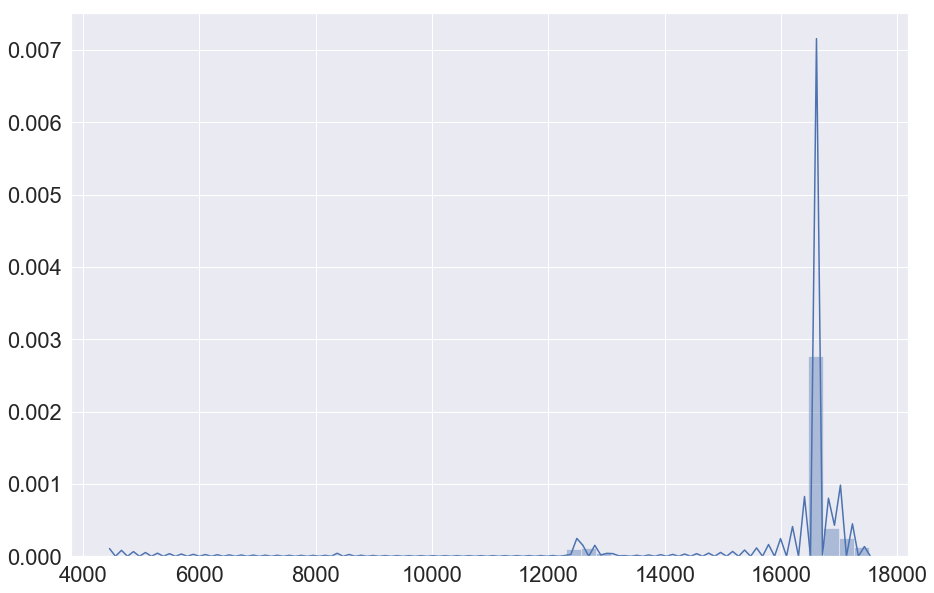

In [496]:
fig, ax = plt.subplots(figsize=(15,10))  
sns.set(font_scale=2) 
sns.distplot(greedy_mc)
#plt.text(.5, .75, str(round(confidence * 100)) + '% Confidence Interval', fontsize=25, color='black', ha='center')


# Solve the EV MIP model
solve the model defined in equations 1, 2, and 3 in the Latex report

In [91]:
from gurobi import *
import pandas as pd
from itertools import product
opt_vals_ev = []
##solve the LP model for the first instance
instance = 0
#define the set of n items
set_x = range(0, 10)
##define the set for the scenarios
set_sc = range(0, 1024)
##find all possible 1024 scenarios (we would need this for the LP)
sc = np.array(list(product([1, 0], repeat = 10)))
##match the probabilities associated with each scenario (once multiplied, 
##this would result in the pi vector in our objective)
prob = np.prod((sc*pie[instance,:]+(1-sc)*(1-pie[instance,:])), axis=1)
##EV MODEL 
model_ev = Model('EV model')
# add the decision variables (x-s)
decision_vars = {(i):model_ev.addVar(vtype=GRB.BINARY,
                        name="x_{0}".format(i)) for i in set_x}
# add the decision variables (x-s)u
du ={(i): model_ev.addVar(name="delta_u", lb=-10000) for i in set_sc}
du1 ={(i): model_ev.addVar(name="delta_u1", lb=-10000) for i in set_sc}
# >= constraints
constraints = {j: 
model_ev.addConstr(
        du1[j] == K - quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x),
        name="constraint1_{0}".format(j))
    for j in set_sc}
constraints1 = {j :
    model_ev.addConstr(du[j] == min_(0, du1[j]), name="constraint2_{0}".format(j)) for j in set_sc}
#objective function
obj = quicksum(prob[j]*quicksum(r_i[instance, i]*(sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) for j in set_sc) + quicksum(prob[j]*p*du[j] for j in set_sc)
model_ev.setObjective(obj, GRB.MAXIMIZE)
model_ev.optimize()

opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                columns = ["variable_object"])
# get the optimal values
opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
opt_df.drop(columns=["variable_object"], inplace=True)
df_ev = opt_df["solution_value"]
opt_vals_ev.append(model_ev.objVal)


Optimize a model with 1024 rows, 2058 columns and 10240 nonzeros
Model has 1024 general constraints
Variable types: 2048 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e-08, 4e+03]
  Bounds range     [1e+00, 1e+04]
  RHS range        [4e+02, 4e+02]
Presolve removed 345 rows and 1369 columns
Presolve time: 0.03s
Presolved: 679 rows, 689 columns, 6927 nonzeros
Variable types: 670 continuous, 19 integer (19 binary)

Root relaxation: objective 1.737750e+04, 359 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17377.4956    0    8          - 17377.4956      -     -    0s
H    0     0                    17186.898635 17377.4956  1.11%     -    0s
     0     0 17357.8491    0    9 17186.8986 17357.8491  0.99%     -    0s
     0     0 17354.3853    0    9 17186.8986 17354.3853  0.97%     - 

In [461]:
from gurobi import *
import pandas as pd
from itertools import product
opt_vals_ev = []
##solve the LP model for the first instance
instance = 0
#define the set of n items
set_x = range(0, 10)
##define the set for the scenarios
set_sc = range(0, 1024)
##find all possible 1024 scenarios (we would need this for the LP)
sc = np.array(list(product([1, 0], repeat = 10)))
##match the probabilities associated with each scenario (once multiplied, 
##this would result in the pi vector in our objective)
prob = np.prod((sc*pie[instance,:]+(1-sc)*(1-pie[instance,:])), axis=1)
##EV MODEL 
model_ev = Model('EV model')
# add the decision variables (x-s)
decision_vars = {(i):model_ev.addVar(vtype=GRB.BINARY,
                        name="x_{0}".format(i)) for i in set_x}
# add the auxiliary variable 
du ={(i): model_ev.addVar(name="delta_u", lb=0) for i in set_sc}
constraints = {j: 
model_ev.addConstr(
        du[j] >= quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x)-K,
        name="constraint1_{0}".format(j))
    for j in set_sc}
#objective function
obj = quicksum(prob[j]*quicksum(r_i[instance, i]*(sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) for j in set_sc) - quicksum(prob[j]*p*du[j] for j in set_sc)
model_ev.setObjective(obj, GRB.MAXIMIZE)
model_ev.optimize()

opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                columns = ["variable_object"])
# get the optimal values
opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
opt_df.drop(columns=["variable_object"], inplace=True)
df_ev = opt_df["solution_value"]
opt_vals_ev.append(model_ev.objVal)
#

Optimize a model with 1024 rows, 1034 columns and 10240 nonzeros
Variable types: 1024 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e-08, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective 11953.973966
Found heuristic solution: objective 13339.345768
Presolve removed 327 rows and 327 columns
Presolve time: 0.02s
Presolved: 697 rows, 707 columns, 7114 nonzeros
Variable types: 691 continuous, 16 integer (16 binary)

Root relaxation: objective 1.738290e+04, 381 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17382.9006    0    8 13339.3458 17382.9006  30.3%     -    0s
H    0     0                    17270.421338 17382.9006  0.65%     -    0s
     0     0 17379.7069    0    9 17270.4213 17379.7069  0.63%     -    0s
     0 

In [117]:
df_ev

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    0.0
8    0.0
9    0.0
Name: solution_value, dtype: float64

In [462]:
for i in range(1, 10):
    instance = i
    prob = np.prod((sc*pie[instance,:]+(1-sc)*(1-pie[instance,:])), axis=1)
    ##EV MODEL 
    model_ev = Model('EV model')
    # add the decision variables (x-s)
    decision_vars = {(i):model_ev.addVar(vtype=GRB.BINARY,
                            name="x_{0}".format(i)) for i in set_x}
    # add the decision variables (x-s)
    du ={(i): model_ev.addVar(name="delta_u", lb=0) for i in set_sc}
    #du1 ={(i): model_ev.addVar(name="delta_u1", lb=-10000) for i in set_sc}
    # >= constraints
    constraints = {j: 
    model_ev.addConstr(
            du[j] >= quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x)-K,
            name="constraint1_{0}".format(j))
        for j in set_sc}
    #objective function
    obj = quicksum(prob[j]*quicksum(r_i[instance, i]*(sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) for j in set_sc) - quicksum(prob[j]*p*du[j] for j in set_sc)
    model_ev.setObjective(obj, GRB.MAXIMIZE)
    #solve in quiet mode
    model_ev.setParam('OutputFlag', 0)
    model_ev.optimize()

    opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                    columns = ["variable_object"])
    # get the optimal values
    opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
    opt_df.drop(columns=["variable_object"], inplace=True)
    df_ev = pd.concat([df_ev, opt_df], axis=1)
    opt_vals_ev.append(model_ev.objVal)

In [464]:
opt_vals_ev

[17270.421338256365,
 17236.6192686298,
 17263.379922946766,
 17278.47780954844,
 17263.97492497702,
 17276.753277001157,
 17251.59723747707,
 17239.99292195476,
 17223.53160006428,
 17235.599396630867]

show the solved instances

In [463]:
df_ev

,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
8,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
9,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0


# Solve the CVaR model
this is the solution to the model defined by eq-s 4, 5, 6, 7

In [465]:
from itertools import product
#solve for the first instance
opt_vals_cvar = []
instance = 0
##define the set for the scenarios
set_sc = range(0, 1024)
##find all possible 1024 scenarios (we would need this for the LP)
sc = np.array(list(product([1, 0], repeat = 10)))
##match the probabilities associated with each scenario (once multiplied, 
##this would result in the pi vector in our objective)
prob = np.prod((sc*pie[instance,:]+(1-sc)*(1-pie[instance,:])), axis=1)
##define the CVaR
model_cvar = Model('CVaR model')
##add the decision variables to the model (the x-s)
decision_vars = {(i):model_cvar.addVar(vtype=GRB.BINARY,
                            name="x_{0}".format(i)) for i in set_x}
##add the s-vector to the model
sc_vars = {(i):model_cvar.addVar(name="s_{0}".format(i)) for i in set_sc}
du = {(i):model_cvar.addVar(name="du_{0}".format(i), lb=0) for i in set_sc}
##add the eta 
eta_var = model_cvar.addVar(name='eta') 
##define the first constraint
##define the capacity related constraint
constraints = {j: 
    model_cvar.addConstr(
            du[j] >= quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x)-K,
            name="constraint1_{0}".format(j))
        for j in set_sc}
constraints = {j : 
model_cvar.addConstr(
        lhs = eta_var - (quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i]*r_i[instance,i] for i in set_x) - p*du[j])-sc_vars[j],
        sense=GRB.LESS_EQUAL,
        rhs=0, 
        name="constraint_1_{0}".format(j))
    for j in set_sc}

##define the objective function
obj_cvar = eta_var - 1/(1-r_cvar)*quicksum(prob[j]*sc_vars[j] for j in set_sc)
##add obj to the model
model_cvar.setObjective(obj_cvar, GRB.MAXIMIZE)
##maximize
model_cvar.optimize()
opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                columns = ["variable_object"])
# get the optimal values
opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
opt_df.drop(columns=["variable_object"], inplace=True)
df_cvar = opt_df["solution_value"]
opt_vals_cvar.append(model_cvar.objVal)


Optimize a model with 2048 rows, 2059 columns and 22528 nonzeros
Variable types: 2049 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e-08, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 327 rows and 327 columns
Presolve time: 0.04s
Presolved: 1721 rows, 1732 columns, 19075 nonzeros
Variable types: 1722 continuous, 10 integer (10 binary)

Root relaxation: objective 1.499493e+04, 891 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 14994.9317    0    8   -0.00000 14994.9317      -     -    0s
H    0     0                    12305.841449 14994.9317  21.9%     -    0s
     0     0 14983.7824    0    8 12305.8414 14983.7824  21.8%     -    0s
H    0     0                    13874.739014 14983.782

In [466]:
df_cvar

0    0.0
1    0.0
2    1.0
3    1.0
4    0.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: solution_value, dtype: float64

In [467]:
for i in range(1, 10):
    instance = i
    prob = np.prod((sc*pie[instance,:]+(1-sc)*(1-pie[instance,:])), axis=1)
    ##define the CVaR
    model_cvar = Model('CVaR model')
    ##add the decision variables to the model (the x-s)
    decision_vars = {(i):model_cvar.addVar(vtype=GRB.BINARY,
                                name="x_{0}".format(i)) for i in set_x}
    ##add the s-vector to the model
    sc_vars = {(i):model_cvar.addVar(name="s_{0}".format(i)) for i in set_sc}
    #du1 = {(i):model_cvar.addVar(name="du1_{0}".format(i), lb=-10000) for i in set_sc}
    du = {(i):model_cvar.addVar(name="du_{0}".format(i), lb=0) for i in set_sc}
    ##add the eta 
    eta_var = model_cvar.addVar(name='eta') 
    ##define the first constraint
    constraints = {j: 
    model_cvar.addConstr(
            du[j] >= quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x)-K,
            name="constraint1_{0}".format(j))
        for j in set_sc}
    constraints = {j : 
    model_cvar.addConstr(
            lhs = eta_var - (quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i]*r_i[instance,i] for i in set_x) - p*du[j]) - sc_vars[j],
            sense=GRB.LESS_EQUAL,
            rhs=0, 
            name="constraint_1_{0}".format(j))
        for j in set_sc}
    ##define the capacity related constraint
    ##define the objective function
    obj_cvar = eta_var - 1/(1-r_cvar)*quicksum(prob[j]*sc_vars[j] for j in set_sc)
    ##add obj to the model
    model_cvar.setObjective(obj_cvar, GRB.MAXIMIZE)
    ##maximize
    model_cvar.setParam('OutputFlag', 0)
    model_cvar.optimize()
    opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                    columns = ["variable_object"])
    # get the optimal values
    opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
    opt_df.drop(columns=["variable_object"], inplace=True)
    df_cvar = pd.concat([df_cvar, opt_df], axis=1)
    opt_vals_cvar.append(model_cvar.objVal)
    

In [468]:
df_cvar

,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value,solution_value
0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0
1,0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0
2,1.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
3,1.0,1.0,0.0,-0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0
4,0.0,1.0,1.0,1.0,1.0,1.0,-0.0,1.0,1.0,1.0
5,1.0,-0.0,1.0,1.0,1.0,1.0,1.0,-0.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [469]:
opt_vals_cvar

[13874.73901366817,
 13952.749356504111,
 13977.31447407206,
 14031.060878506021,
 13986.087785963595,
 13942.862366631965,
 14006.382839699527,
 13901.951483742276,
 13953.528897881602,
 13927.171414909788]

# Question 6 
analyze the effects of the risk, capacity, and penalty on the objective

analysis on risk

In [352]:
from joblib import load, dump
from gurobi import *
import pandas as pd
from itertools import product
import os
path="/Users/geri/Documents/tisem/uncertainty/"
os.chdir(path)
df_risk = pd.DataFrame(columns=['Risk','Instance','Objective', 'x1','x2','x3','x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
df_ind = 0
#solve many models
##define the set for the scenarios
set_sc = range(0, 1024)
##find all possible 1024 scenarios (we would need this for the LP)
sc = np.array(list(product([1, 0], repeat = 10)))
set_x = range(0, 10)
risk_range = np.arange(0, 1.1, 0.1)
for risks in risk_range:
    r_cvar = risks
    for i in range(0, 10):
        instance = i
        prob = np.prod((sc*pie[instance,:]+(1-sc)*(1-pie[instance,:])), axis=1)
        ##define the CVaR
        model_cvar = Model('CVaR model')
        ##add the decision variables to the model (the x-s)
        decision_vars = {(i):model_cvar.addVar(vtype=GRB.BINARY,
                                name="x_{0}".format(i)) for i in set_x}
        ##add the s-vector to the model
        sc_vars = {(i):model_cvar.addVar(name="s_{0}".format(i)) for i in set_sc}
        du = {(i):model_cvar.addVar(name="du_{0}".format(i), lb=0) for i in set_sc}
        ##add the eta 
        eta_var = model_cvar.addVar(name='eta') 
        ##define the first constraint
        constraints = {j: 
        model_cvar.addConstr(
            du[j] >= quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) - K,
            name="constraint1_{0}".format(j))
        for j in set_sc}
        constraints = {j : 
        model_cvar.addConstr(
            lhs = eta_var - (quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i]*r_i[instance,i] for i in set_x) - p*du[j]) - sc_vars[j],
            sense=GRB.LESS_EQUAL,
            rhs=0, 
            name="constraint_1_{0}".format(j))
        for j in set_sc}
        ##define the capacity related constraint
        ##define the objective function
        obj_cvar = eta_var - 1/(1-r_cvar)*quicksum(prob[j]*sc_vars[j] for j in set_sc)
        ##add obj to the model
        model_cvar.setObjective(obj_cvar, GRB.MAXIMIZE)
        ##maximize
        model_cvar.setParam('OutputFlag', 0)
        model_cvar.optimize()
        opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                        columns = ["variable_object"])
        opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
        opt_df.drop(columns=["variable_object"], inplace=True) 
        df_risk.loc[df_ind, 3:] = opt_df.transpose().values
        df_risk.iloc[df_ind, 0] = r_cvar
        df_risk.iloc[df_ind, 1] = i
        df_risk.iloc[df_ind, 2] = model_cvar.objVal
        df_ind+=1

/Users/geri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning:

divide by zero encountered in double_scalars



GurobiError: Multiplier is Nan or Inf

analysis on penalty

In [211]:
df_risk.iloc[df_ind, 0]

nan

In [353]:
df_risk

,Risk,Instance,Objective,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0,0,17272.7,1,1,1,1,1,1,1,0,-0,-0
1,0,1,17274.6,1,1,1,1,1,1,1,0,-0,0
2,0,2,17241.1,1,1,1,1,1,1,1,-0,-0,-0
3,0,3,17252.9,1,1,1,1,1,1,1,-0,-0,-0
4,0,4,17227.3,1,1,1,1,1,1,1,-0,-0,-0
5,0,5,17243.5,1,1,1,1,1,1,1,-0,-0,-0
6,0,6,17289.3,1,1,1,1,1,1,1,-0,-0,-0
7,0,7,17214,1,1,1,1,1,1,1,0,-0,0
8,0,8,17251.6,1,1,1,1,1,1,1,-0,0,-0
9,0,9,17288.2,1,1,1,1,1,1,1,-0,-0,-0


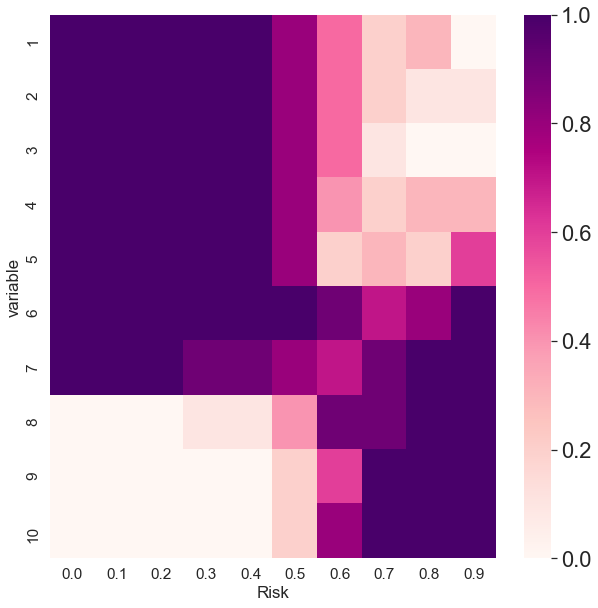

In [368]:
df_risk_new = df_risk.apply(pd.to_numeric)
df_risk_new = df_risk_new.groupby('Risk').mean().reset_index()
df_risk_new.drop(columns=['Instance', 'Objective'], inplace=True)
test_risk = pd.melt(df_risk_new, id_vars=['Risk'], value_vars=['x1','x2','x3','x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
test_risk['Risk'] = round(test_risk['Risk'], 2)
tedi = {'x1': 1,'x2': 2,'x3': 3,'x4': 4,'x5': 5, 'x6': 6, 'x7': 7, 'x8': 8, 'x9': 9, 'x10': 10}
test_risk = test_risk.replace({"variable": tedi})
test_risk = test_risk.pivot("variable", "Risk", "value")
fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=2) 
ax = sns.heatmap(test_risk, cmap="RdPu")

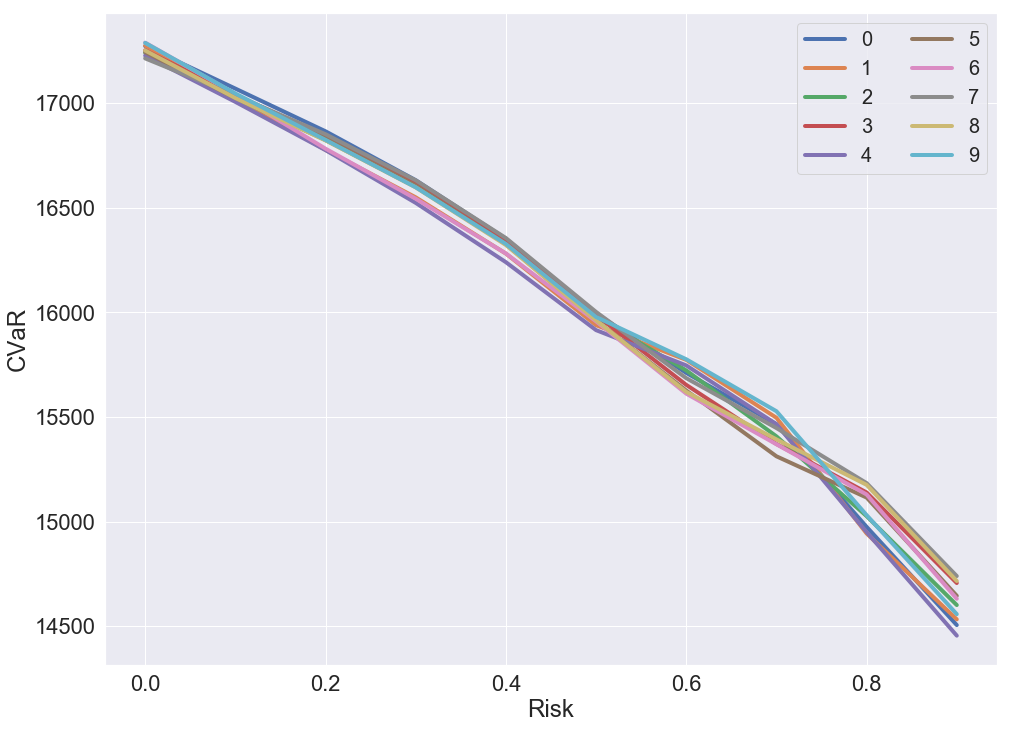

In [379]:
df_risk_obj = df_risk[['Risk', 'Instance', 'Objective']].apply(pd.to_numeric)
df_risk_obj_test = df_risk_obj.pivot(index="Risk", columns="Instance", values="Objective")
f = plt.figure(figsize=(16, 12))
plt.plot(df_risk_obj_test, linewidth=4.0)
plt.legend(list(df_risk_obj_test), ncol=2, loc='upper right', fontsize=20)
plt.xlabel('Risk', fontsize=24)
plt.ylabel('CVaR', fontsize=24)
plt.show()

In [357]:
from joblib import load, dump
from gurobi import *
import pandas as pd
from itertools import product
import os
path="/Users/geri/Documents/tisem/uncertainty/"
os.chdir(path)
#solve many models
##define the set for the scenarios
set_sc = range(0, 1024)
##find all possible 1024 scenarios (we would need this for the LP)
sc = np.array(list(product([1, 0], repeat = 10)))
set_x = range(0, 10)
penalties_range = np.arange(0, 200, 10)
r_cvar = 0.95
df_pen = pd.DataFrame(columns=['Penalty','Instance','Objective', 'x1','x2','x3','x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
df_ind = 0
for penalty in penalties_range:
    p = penalty
    for i in range(0, 10):
        instance = i
        prob = np.prod((sc*pie[instance,:]+(1-sc)*(1-pie[instance,:])), axis=1)
        ##define the CVaR
        model_cvar = Model('CVaR model')
        ##add the decision variables to the model (the x-s)
        decision_vars = {(i):model_cvar.addVar(vtype=GRB.BINARY,
                                name="x_{0}".format(i)) for i in set_x}
        ##add the s-vector to the model
        sc_vars = {(i):model_cvar.addVar(name="s_{0}".format(i)) for i in set_sc}
        du = {(i):model_cvar.addVar(name="du_{0}".format(i), lb=0) for i in set_sc}
        ##add the eta 
        eta_var = model_cvar.addVar(name='eta') 
        ##define the first constraint
        constraints = {j: 
        model_cvar.addConstr(
            du[j] >= quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) - K,
            name="constraint1_{0}".format(j))
        for j in set_sc}
        constraints = {j : 
        model_cvar.addConstr(
            lhs = eta_var - (quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i]*r_i[instance,i] for i in set_x) - p*du[j]) - sc_vars[j],
            sense=GRB.LESS_EQUAL,
            rhs=0, 
            name="constraint_1_{0}".format(j))
        for j in set_sc}
        ##define the capacity related constraint
        ##define the objective function
        obj_cvar = eta_var - 1/(1-r_cvar)*quicksum(prob[j]*sc_vars[j] for j in set_sc)
        ##add obj to the model
        model_cvar.setObjective(obj_cvar, GRB.MAXIMIZE)
        ##maximize
        model_cvar.setParam('OutputFlag', 0)
        model_cvar.optimize()
        opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                        columns = ["variable_object"])
        opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
        opt_df.drop(columns=["variable_object"], inplace=True) 
        df_pen.loc[df_ind, 3:] = opt_df.transpose().values
        df_pen.iloc[df_ind, 0] = penalty
        df_pen.iloc[df_ind, 1] = i
        df_pen.iloc[df_ind, 2] = model_cvar.objVal
        df_ind+=1

In [370]:
df_pen

,Penalty,Instance,Objective,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0,0,22572.7,1,1,1,1,1,1,1,1,1,1
1,0,1,22488,1,1,1,1,1,1,1,1,1,1
2,0,2,21975.4,1,1,1,1,1,1,1,1,1,1
3,0,3,21585.3,1,1,1,1,1,1,1,1,1,1
4,0,4,22057.9,1,1,1,1,1,1,1,1,1,1
5,0,5,21715.4,1,1,1,1,1,1,1,1,1,1
6,0,6,22208.9,1,1,1,1,1,1,1,1,1,1
7,0,7,21335.8,1,1,1,1,1,1,1,1,1,1
8,0,8,21704.7,1,1,1,1,1,1,1,1,1,1
9,0,9,22552,1,1,1,1,1,1,1,1,1,1


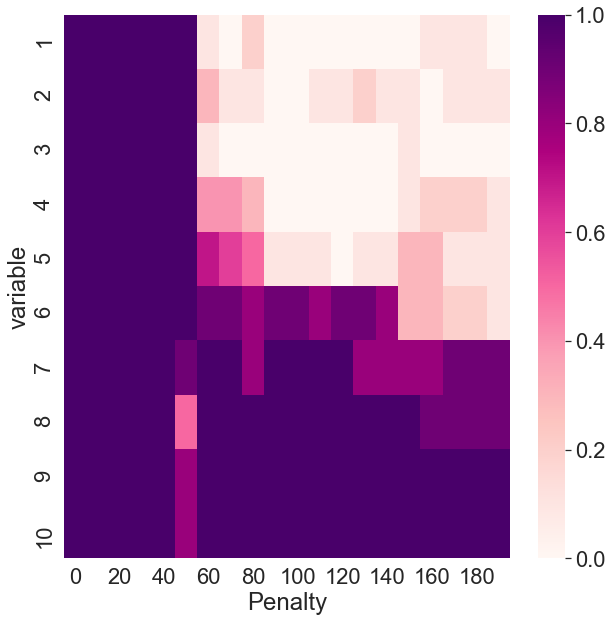

In [371]:
df_pen_new = df_pen.apply(pd.to_numeric)
df_pen_new = df_pen_new.groupby('Penalty').mean().reset_index()
df_pen_new.drop(columns=['Instance', 'Objective'], inplace=True)
test = pd.melt(df_pen_new, id_vars=['Penalty'], value_vars=['x1','x2','x3','x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
tedi = {'x1': 1,'x2': 2,'x3': 3,'x4': 4,'x5': 5, 'x6': 6, 'x7': 7, 'x8': 8, 'x9': 9, 'x10': 10}
test = test.replace({"variable": tedi})
test = test.pivot("variable", "Penalty", "value")
fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=2) 
ax = sns.heatmap(test, cmap="RdPu")

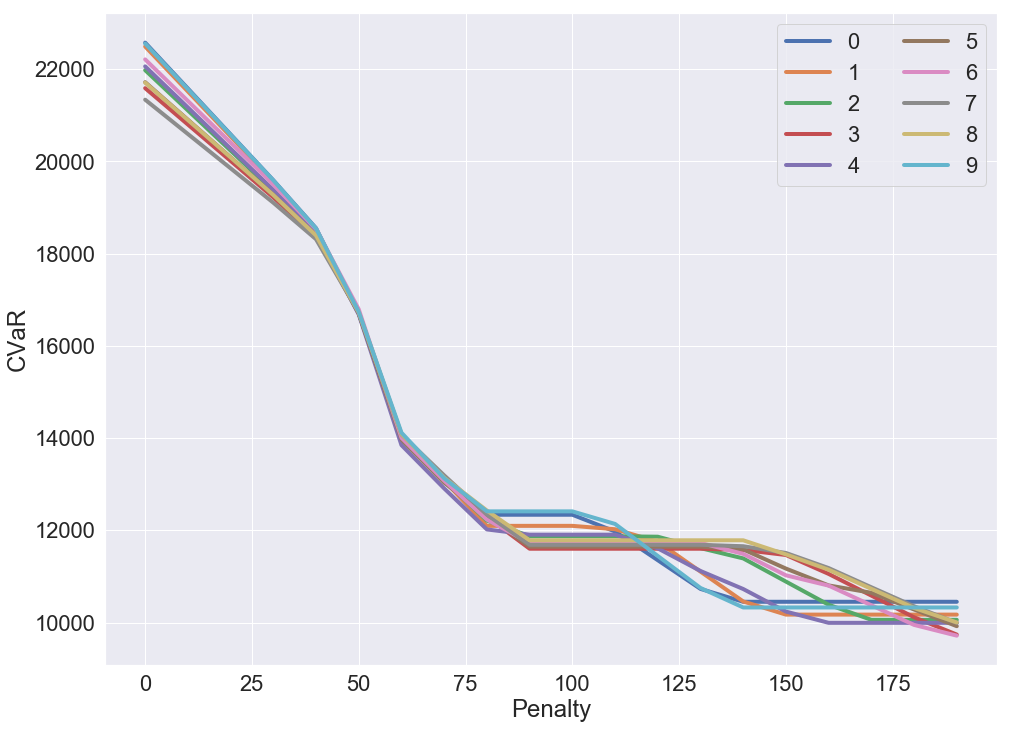

In [380]:
df_pen_obj = df_pen[['Penalty', 'Instance', 'Objective']].apply(pd.to_numeric)
df_pen_obj_test = df_pen_obj.pivot(index="Penalty", columns="Instance", values="Objective")
f = plt.figure(figsize=(16, 12))
plt.plot(df_pen_obj_test, linewidth=4.0)
plt.legend(list(df_pen_obj_test), ncol=2, loc='upper right', fontsize=22)
plt.xlabel('Penalty', fontsize=24)
plt.ylabel('CVaR', fontsize=24)
plt.show()

# analysis on capacity

In [326]:
from joblib import load, dump
from gurobi import *
import pandas as pd
from itertools import product
import os
path="/Users/geri/Documents/tisem/uncertainty/"
os.chdir(path)
#solve many models
##define the set for the scenarios
set_sc = range(0, 1024)
##find all possible 1024 scenarios (we would need this for the LP)
sc = np.array(list(product([1, 0], repeat = 10)))
set_x = range(0, 10)
capacity_range = np.arange(0, 1000, 50)
df_cap = pd.DataFrame(columns=['Capacity','Instance','Objective', 'x1','x2','x3','x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
df_ind = 0
r_cvar = 0.95
p=60+g/10
for capacity in capacity_range:
    K = capacity
    for i in range(0, 10):
        instance = i
        prob = np.prod((sc*pie[instance,:]+(1-sc)*(1-pie[instance,:])), axis=1)
        ##define the CVaR
        model_cvar = Model('CVaR model')
        ##add the decision variables to the model (the x-s)
        decision_vars = {(i):model_cvar.addVar(vtype=GRB.BINARY,
                                name="x_{0}".format(i)) for i in set_x}
        ##add the s-vector to the model
        sc_vars = {(i):model_cvar.addVar(name="s_{0}".format(i)) for i in set_sc}
        du = {(i):model_cvar.addVar(name="du_{0}".format(i), lb=0) for i in set_sc}
        ##add the eta 
        eta_var = model_cvar.addVar(name='eta') 
        ##define the first constraint
        constraints = {j: 
        model_cvar.addConstr(
            du[j] >= quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) - K,
            name="constraint1_{0}".format(j))
        for j in set_sc}
        constraints = {j : 
        model_cvar.addConstr(
            lhs = eta_var - (quicksum((sc[j,i]*d_h[instance,i]+(1-sc[j,i])*d_l[instance,i])*decision_vars[i]*r_i[instance,i] for i in set_x) - p*du[j]) - sc_vars[j],
            sense=GRB.LESS_EQUAL,
            rhs=0, 
            name="constraint_1_{0}".format(j))
        for j in set_sc}
        ##define the capacity related constraint
        ##define the objective function
        obj_cvar = eta_var - 1/(1-r_cvar)*quicksum(prob[j]*sc_vars[j] for j in set_sc)
        ##add obj to the model
        model_cvar.setObjective(obj_cvar, GRB.MAXIMIZE)
        ##maximize
        model_cvar.setParam('OutputFlag', 0)
        model_cvar.optimize()
        opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                        columns = ["variable_object"])
        opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
        opt_df.drop(columns=["variable_object"], inplace=True) 
        df_cap.loc[df_ind, 3:] = opt_df.transpose().values
        df_cap.iloc[df_ind, 0] = K
        df_cap.iloc[df_ind, 1] = i
        df_cap.iloc[df_ind, 2] = model_cvar.objVal
        df_ind+=1

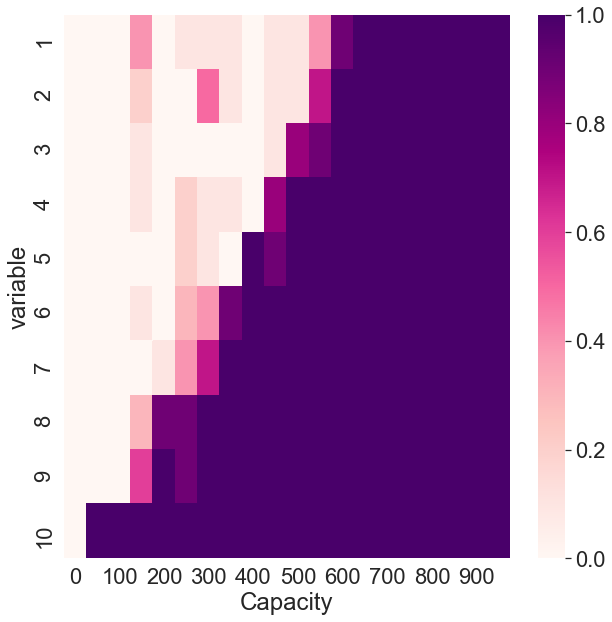

In [375]:
df_cap_new = df_cap.apply(pd.to_numeric)
df_cap_new = df_cap_new.groupby('Capacity').mean().reset_index()
df_cap_new.drop(columns=['Instance', 'Objective'], inplace=True)
test_cap = pd.melt(df_cap_new, id_vars=['Capacity'], value_vars=['x1','x2','x3','x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
tedi = {'x1': 1,'x2': 2,'x3': 3,'x4': 4,'x5': 5, 'x6': 6, 'x7': 7, 'x8': 8, 'x9': 9, 'x10': 10}
test_cap = test_cap.replace({"variable": tedi})
test_cap = test_cap.pivot("variable", "Capacity", "value")
fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=2) 
ax = sns.heatmap(test_cap, cmap="RdPu")

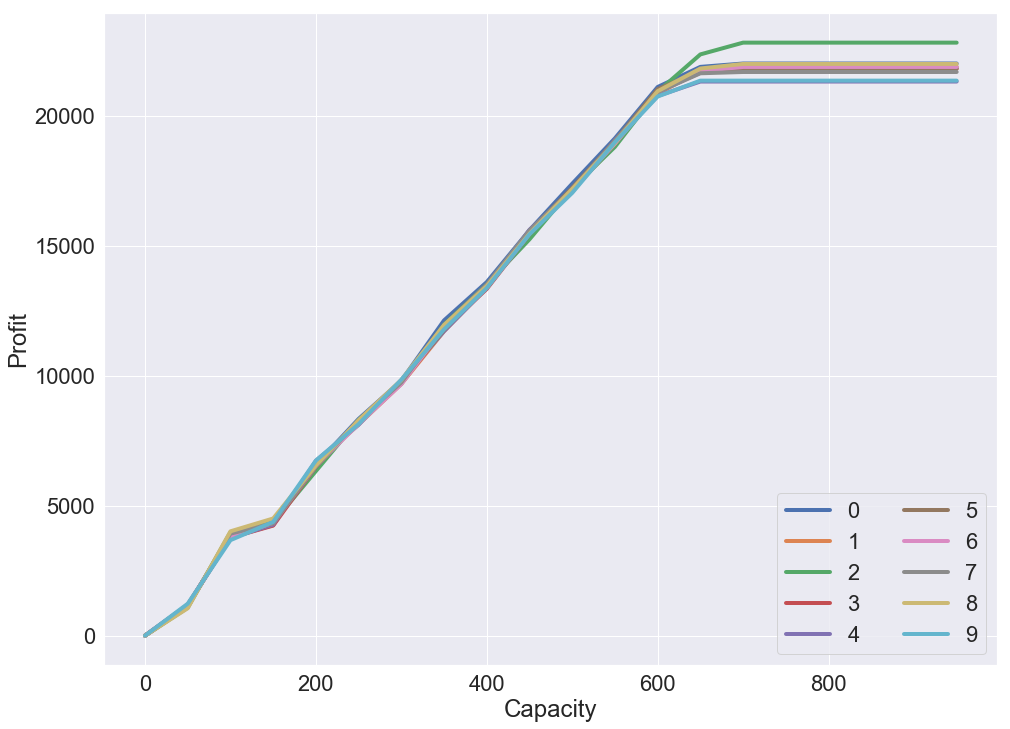

In [381]:
df_cap_obj = df_cap[['Capacity', 'Instance', 'Objective']].apply(pd.to_numeric)
df_cap_obj_test = df_cap_obj.pivot(index="Capacity", columns="Instance", values="Objective")
f = plt.figure(figsize=(16, 12))
plt.plot(df_cap_obj_test, linewidth=4.0)
plt.legend(list(df_cap_obj_test), ncol=2, loc='lower right', fontsize=22)
plt.xlabel('Capacity', fontsize=24)
plt.ylabel('Profit', fontsize=24)
plt.show()

# 7b: EV 
Solve the EV 

draw the scenarios

In [384]:
from scipy.stats import bernoulli
n_draws = 15000
instance = 0
random_sc = np.zeros((n_draws, 10))
random_weights = np.zeros((n_draws, 10))
for i in range(0, 10):
    random_sc[:, i] = np.transpose(bernoulli.rvs(pie[instance,i], size=n_draws))


# SAA approximation
just one instance for the candidate solution

In [389]:
##solve the LP model for the first instance
instance = 0
#define the set of n items
set_x = range(0, 10)
##define the set for the scenarios
set_sc = range(0, n_draws)
##this would result in the pi vector in our objective)
#prob = np.prod((random_sc*pie[instance,:]+(1-random_sc)*(1-pie[instance,:])), axis=1)
##EV MODEL 
model_saa = Model('SAA model')
# add the decision variables (x-s)
decision_vars = {(i):model_saa.addVar(vtype=GRB.BINARY,
                        name="x_{0}".format(i)) for i in set_x}
# add the decision variables (x-s)
du ={(i): model_saa.addVar(name="delta_u", lb=0) for i in set_sc}
# >= constraints
constraints = {j: 
model_saa.addConstr(
        du[j] >= quicksum((random_sc[j,i]*d_h[instance,i]+(1-random_sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x)-K,
        name="constraint1_{0}".format(j))
    for j in set_sc}
#objective function
obj = (1/n_draws)*quicksum(quicksum(r_i[instance, i]*(random_sc[j,i]*d_h[instance,i]+(1-random_sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) for j in set_sc) - (1/n_draws)*quicksum(p*du[j] for j in set_sc)
model_saa.setObjective(obj, GRB.MAXIMIZE)
model_saa.optimize()

opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                columns = ["variable_object"])
# get the optimal values
opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
opt_df.drop(columns=["variable_object"], inplace=True)
df_saa = opt_df["solution_value"]
#opt_vals_ev.append(model_ev.objVal)

Optimize a model with 15000 rows, 15010 columns and 155296 nonzeros
Variable types: 15000 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [4e-03, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective 12012.974257
Found heuristic solution: objective 13314.847753
Presolve removed 14651 rows and 14651 columns
Presolve time: 0.17s
Presolved: 349 rows, 359 columns, 3553 nonzeros
Variable types: 348 continuous, 11 integer (11 binary)

Root relaxation: objective 1.739226e+04, 321 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17392.2551    0    9 13314.8478 17392.2551  30.6%     -    0s
H    0     0                    17272.164376 17392.2551  0.70%     -    0s
     0     0 17380.7876    0    9 17272.1644 17380.7876  0.63%     -    0s

In [390]:
feasible_x = np.zeros((1, 10))
feasible_x[0,:] = np.array(df_saa)
mean_mc = monte_carlo_sim(d_h[0,:],d_l[0,:], pie[0,:], r_i[0,:], 100000, feasible_x)
print(mean_mc.mean())

17271.52067301137


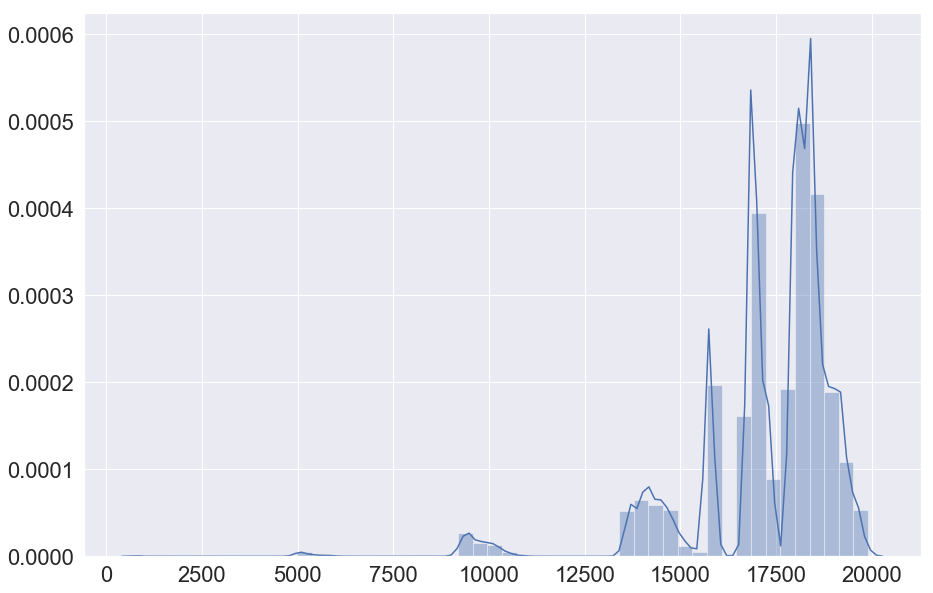

In [408]:
fig, ax = plt.subplots(figsize=(15,10))  
sns.set(font_scale=2) 
sns.distplot(mean_mc);

In [391]:
print(mean_mc.mean())
print(mean_mc.std())

17271.52067301137
1936.717549025051


In [396]:
upper_bound = mean_mc.mean()+1.64*np.sqrt(mean_mc.std())
upper_bound

17343.69404427708

In [472]:
print(K)
print(r_cvar)
print(p)

416
0.95
60.4


In [474]:
lower_bound_draws = 150
saa = np.zeros((1, lower_bound_draws))
instance = 0
n_draws = 15000
df_saa = pd.DataFrame(columns=['Objective', 'x1','x2','x3','x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
df_ind = 0
for k in range(0, lower_bound_draws):
    random_sc = np.zeros((n_draws, 10))
    random_weights = np.zeros((n_draws, 10))
    for i in range(0, 10):
        random_sc[:, i] = np.transpose(bernoulli.rvs(pie[instance,i], size=n_draws))
    #define the set of n items
    set_x = range(0, 10)
    ##define the set for the scenarios
    set_sc = range(0, n_draws)
    ##this would result in the pi vector in our objective)
    #prob = np.prod((random_sc*pie[instance,:]+(1-random_sc)*(1-pie[instance,:])), axis=1)
    ##EV MODEL 
    model_saa = Model('SAA model')
    # add the decision variables (x-s)
    decision_vars = {(i):model_saa.addVar(vtype=GRB.BINARY,
                            name="x_{0}".format(i)) for i in set_x}
    # add the decision variables (x-s)
    du ={(i): model_saa.addVar(name="delta_u", lb=0) for i in set_sc}
    # >= constraints
    constraints = {j: 
    model_saa.addConstr(
            du[j] >= quicksum((random_sc[j,i]*d_h[instance,i]+(1-random_sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) - K,
            name="constraint1_{0}".format(j))
        for j in set_sc}
    #objective function
    obj = (1/n_draws)*quicksum(quicksum(r_i[instance, i]*(random_sc[j,i]*d_h[instance,i]+(1-random_sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x) for j in set_sc) - (1/n_draws)*quicksum(p*du[j] for j in set_sc)
    model_saa.setObjective(obj, GRB.MAXIMIZE)
    model_saa.setParam('OutputFlag', 0)
    model_saa.optimize()
    opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                        columns = ["variable_object"])
    opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
    opt_df.drop(columns=["variable_object"], inplace=True) 
    df_saa.loc[df_ind, 1:] = opt_df.transpose().values
    df_saa.iloc[df_ind, 0] = model_saa.objVal
    df_ind+=1

In [386]:
saa_pd = pd.DataFrame(np.transpose(saa))
saa_pd['SAA'] = pd.DataFrame(np.transpose(saa))

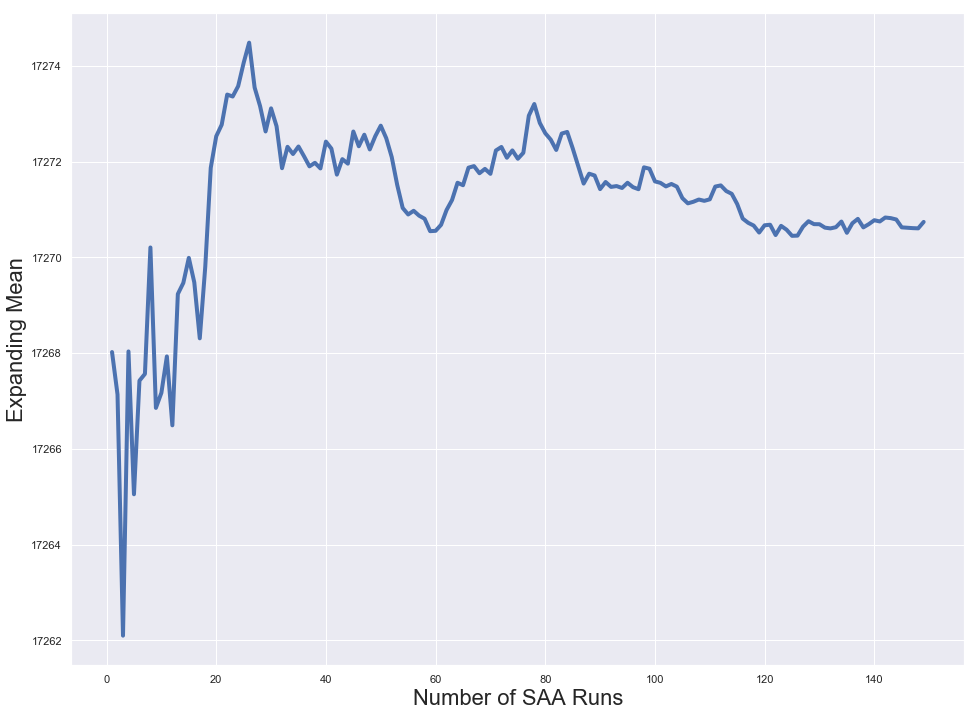

In [388]:
#saa_pd['MA'] = saa_pd['SAA'].expanding(2).mean()
#saa_pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
f = plt.figure(figsize=(16, 12))
plt.plot(saa_pd['MA'], linewidth=4.0)
#plt.legend(list(df_graph), ncol=2, loc='lower right', fontsize=18)
plt.xlabel('Number of SAA Runs', fontsize=22)
plt.ylabel('Expanding Mean', fontsize=22)
plt.show()

#plt.plot(saa_pd['MA'])


In [584]:
saa_pd.max()

0      17332.618787
SAA    17332.618787
MA     17274.486941
dtype: float64

lower bound estimate for the gap

In [149]:
saa.mean()

17287.444913763473

In [393]:
print(saa.mean())
print(saa.std())

17270.742270235703
17.561210968322733


lower bound 

In [394]:
lower_bound = saa.mean()-1.86*np.sqrt(saa.std())
lower_bound

17262.94773590285

In [397]:
gap = upper_bound - lower_bound
gap

80.74630837422956

# SAA CVaR

In [504]:
from scipy.stats import bernoulli
n_draws = 15000
instance = 0
random_sc = np.zeros((n_draws, 10))
random_weights = np.zeros((n_draws, 10))
for i in range(0, 10):
    random_sc[:, i] = np.transpose(bernoulli.rvs(pie[instance,i], size=n_draws))

In [509]:
##solve the SAA model for the first instance
instance = 0
#define the set of n items
set_x = range(0, 10)
##define the set for the scenarios
set_sc = range(0, n_draws)
lower_bound_draws = 150
#saa = np.zeros((1, lower_bound_draws))
instance = 0
n_draws = 15000
df_saa_cvar = pd.DataFrame(columns=['Objective', 'x1','x2','x3','x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10'])
df_ind = 0
for k in range(0, lower_bound_draws):
    random_sc = np.zeros((n_draws, 10))
    random_weights = np.zeros((n_draws, 10))
    for i in range(0, 10):
        random_sc[:, i] = np.transpose(bernoulli.rvs(pie[instance,i], size=n_draws))
    #define the set of n items
    set_x = range(0, 10)
    ##define the set for the scenarios
    set_sc = range(0, n_draws)
    ##this would result in the pi vector in our objective)
    #prob = np.prod((random_sc*pie[instance,:]+(1-random_sc)*(1-pie[instance,:])), axis=1)
    ##EV MODEL 
    model_saa_c = Model('SAA model')
    ##add the decision variables to the model (the x-s)
    decision_vars = {(i):model_saa_c.addVar(vtype=GRB.BINARY,
                                name="x_{0}".format(i)) for i in set_x}
    ##add the s-vector to the model
    sc_vars = {(i):model_saa_c.addVar(name="s_{0}".format(i)) for i in set_sc}
    du = {(i):model_saa_c.addVar(name="du_{0}".format(i), lb=0) for i in set_sc}
    ##add the eta 
    eta_var = model_saa_c.addVar(name='eta') 
    ##define the first constraint
    ##define the capacity related constraint
    constraints = {j: 
        model_saa_c.addConstr(
                du[j] >= quicksum((random_sc[j,i]*d_h[instance,i]+(1-random_sc[j,i])*d_l[instance,i])*decision_vars[i] for i in set_x)-K,
                name="constraint1_{0}".format(j))
            for j in set_sc}
    constraints = {j : 
    model_saa_c.addConstr(
            lhs = eta_var - (quicksum((random_sc[j,i]*d_h[instance,i]+(1-random_sc[j,i])*d_l[instance,i])*decision_vars[i]*r_i[instance,i] for i in set_x) - p*du[j])-sc_vars[j],
            sense=GRB.LESS_EQUAL,
            rhs=0, 
            name="constraint_1_{0}".format(j))
        for j in set_sc}

    ##define the objective function
    obj_cvar = eta_var - 1/(1-r_cvar)*quicksum(1/n_draws*sc_vars[j] for j in set_sc)
    ##add obj to the model
    model_saa_c.setObjective(obj_cvar, GRB.MAXIMIZE)
    ##maximize
    model_saa_c.optimize()
    opt_df = pd.DataFrame.from_dict(decision_vars, orient="index", 
                                        columns = ["variable_object"])
    opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)
    opt_df.drop(columns=["variable_object"], inplace=True) 
    df_saa_cvar.loc[df_ind, 1:] = opt_df.transpose().values
    df_saa_cvar.iloc[df_ind, 0] = model_saa_c.objVal
    #df_saa_cvar.iloc[df_ind, 0] = model_saa_c.objVal
    df_ind+=1
    #opt_vals_ev.append(model_ev.objVal)

Optimize a model with 30000 rows, 30011 columns and 340492 nonzeros
Variable types: 30001 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 29264 rows and 29264 columns
Presolve time: 1.83s
Presolved: 736 rows, 747 columns, 8177 nonzeros
Variable types: 737 continuous, 10 integer (10 binary)

Root relaxation: objective 1.498482e+04, 272 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 14984.8217    0    9   -0.00000 14984.8217      -     -    1s
H    0     0                    10447.231415 14984.8217  43.4%     -    1s
     0     0 14963.7713    0    9 10447.2314 14963.7713  43.2%     -    2s
     0     0 14955.0119    0    8 10447.2314 14955

In [510]:
df_saa_cvar

,Objective,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,13949.5,0,0,0,-0,1,1,1,1,1,1
1,13968,1,-0,1,1,-0,-0,1,1,1,1
2,13918.7,-0,-0,1,1,-0,1,1,1,1,1
3,13934.2,-0,0,-0,-0,1,1,1,1,1,1
4,13894.8,-0,1,1,1,-0,-0,1,1,1,1
5,13853.9,-0,1,1,-0,1,-0,1,1,1,1
6,13905.6,-0,-0,1,1,1,-0,1,1,1,1
7,13913.2,0,1,1,1,0,-0,1,1,1,1
8,13856.8,0,-0,1,1,-0,1,1,1,1,1
9,13899.2,0,1,1,1,0,-0,1,1,1,1


In [585]:
df_saa_cvar['Objective'].max()

14047.050340603018

In [582]:
print(df_saa_cvar['Objective'].mean())
print(df_saa_cvar['Objective'].std())

13918.047127524247
44.479992092817525


In [586]:
saa_pd_c = pd.DataFrame(np.transpose(df_saa_cvar['Objective']))
saa_pd_c['SAA'] = pd.DataFrame(np.transpose(df_saa_cvar['Objective']))

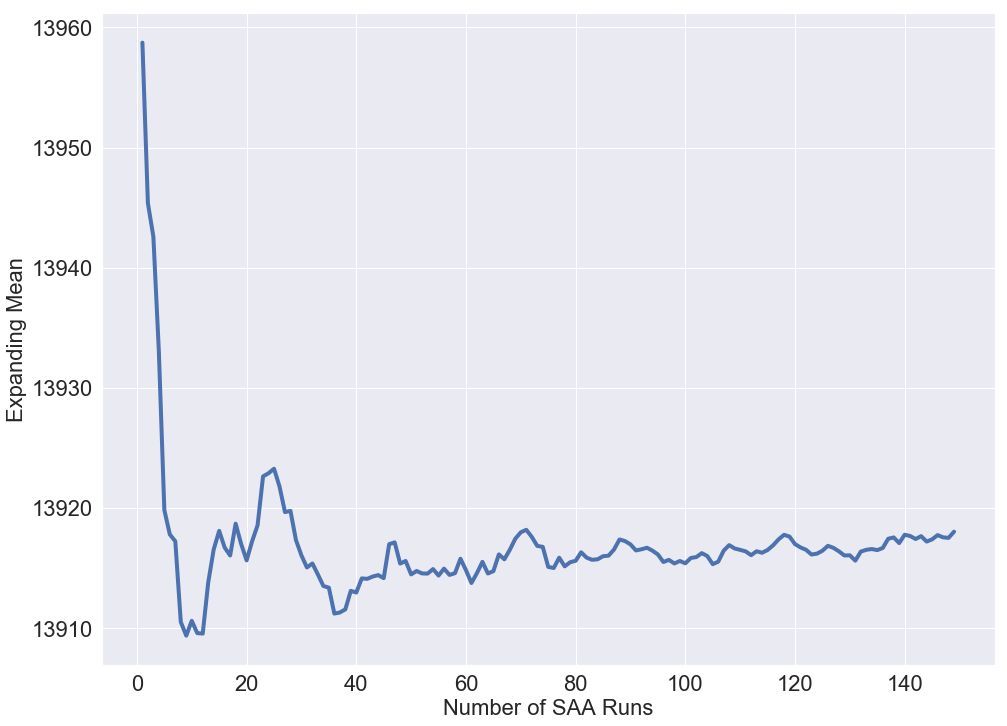

In [587]:
saa_pd_c['MA'] = saa_pd_c['SAA'].expanding(2).mean()
f = plt.figure(figsize=(16, 12))
plt.plot(saa_pd_c['MA'], linewidth=4.0)
#plt.legend(list(df_graph), ncol=2, loc='lower right', fontsize=18)
plt.xlabel('Number of SAA Runs', fontsize=22)
plt.ylabel('Expanding Mean', fontsize=22)
plt.show()

In [521]:
df_saa_cvar['Objective'].max()
df_saa_cvar_val = df_saa_cvar.astype(float)

In [522]:
df_saa_cvar_val['Objective'].idxmax()

46

In [529]:
x_cvar = df_saa_cvar_val.iloc[46, 1:]

In [530]:
x_cvar

x1    -0.0
x2    -0.0
x3    -0.0
x4    -0.0
x5     1.0
x6     1.0
x7     1.0
x8     1.0
x9     1.0
x10    1.0
Name: 46, dtype: float64

In [570]:
#feasible_x_cvar = np.zeros((1, 10))
#feasible_x_cvar[0,:] = np.array(x_cvar)
cvars = []
for i in range(0, 100):
    mean_mc_c = monte_carlo_sim(d_h[0,:],d_l[0,:], pie[0,:], r_i[0,:], 100, feasible_x_cvar)
    cvars.append(mean_mc_c[np.where( mean_mc_c > (np.percentile(mean_mc_c, 5, axis=1 )))].mean())

In [558]:
feasible_x_cvar

array([[-0., -0., -0., -0.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [534]:
cvar = np.percentile(mean_mc_c, 5, axis=1)

In [574]:
len(cvars)
cvars_np = np.asarray(cvars)

In [575]:
print(cvars_np.mean())
print(cvars_np.std())

16701.360749603522
216.90695478274787


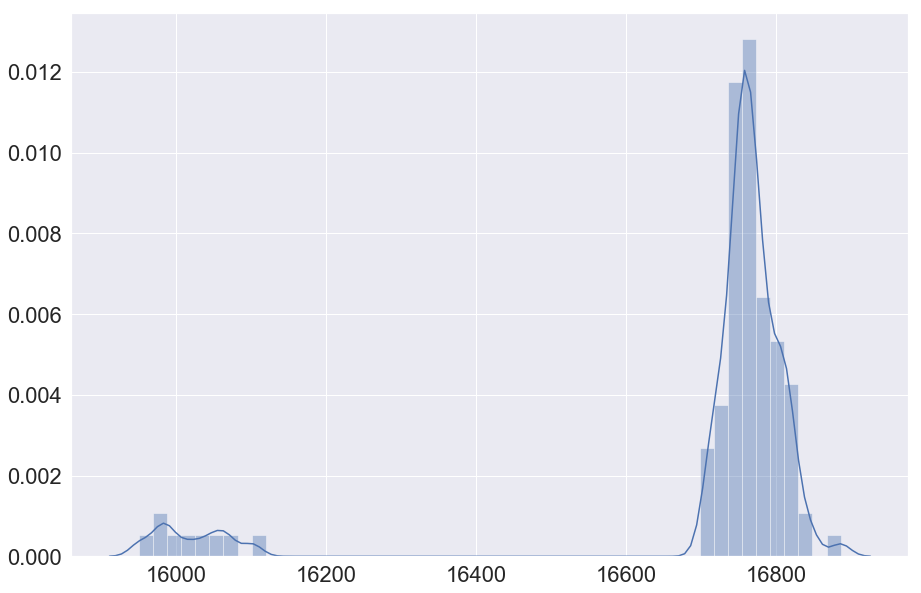

In [577]:
fig, ax = plt.subplots(figsize=(15,10))  
sns.set(font_scale=2) 
sns.distplot(cvars_np);

In [581]:
upper_bound = cvars_np.mean()+1.64*np.sqrt(cvars_np.std())
print(upper_bound)
lower_bound = df_saa_cvar['Objective'].mean()-1.86*np.sqrt(df_saa_cvar['Objective'].std())
print(lower_bound)
print(upper_bound-lower_bound)


16725.514278239803
13905.64216961846
2819.8721086213427
